In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!pip install prophet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 5.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.3/541.3 kB 4.8 MB/s eta 0:00:00a 0:00:01
  Using cached importlib_resources-5.12.0-py3-none-any.whl (36 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 10.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.3 MB/s eta 0:00:00a 0:00:01
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732001 sha256=081e05bf3aad197bbc9770d34ea78468d611fc51a9dc27e56ba907f021cf8388
  Stored in directory: /Users/hadoop/Library/Caches/pip/wheels/04/1f/e5/8dd0c661cd8d252817655dc14a84f7ae045d6616594145aa81
Successfully built pymeeus


In [4]:
from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
pjme = pd.read_csv('data/PJME_hourly.csv',index_col=[0],parse_dates=[0])

In [6]:
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


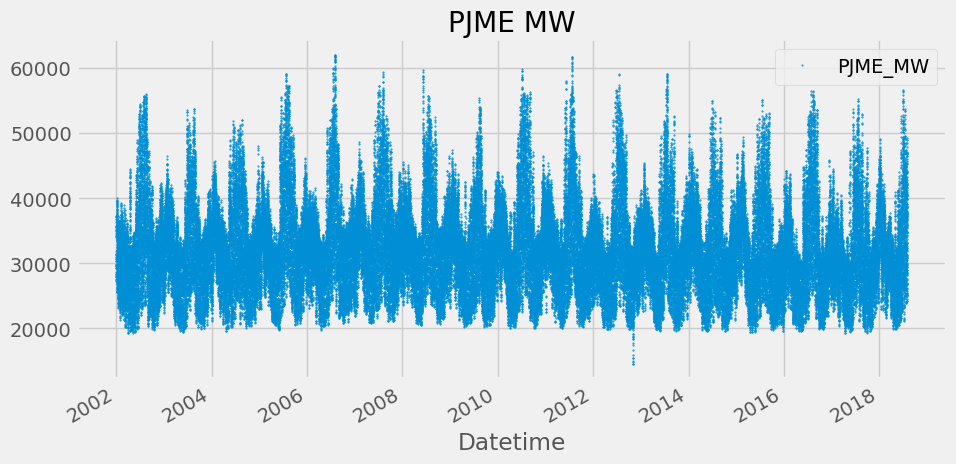

In [7]:
color_pal = sns.color_palette()
pjme.plot(style='.',
         figsize=(10,5),
         ms =1,
         color=color_pal[0],
         title='PJME MW')
plt.show()

# Time Series Features

In [10]:
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],ordered=True)

In [11]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

In [12]:
X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)

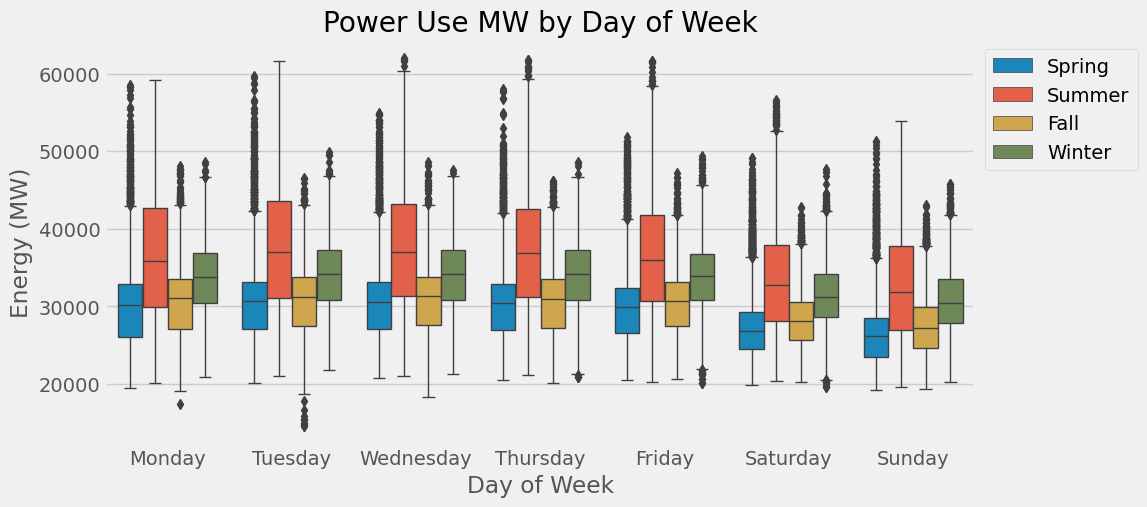

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

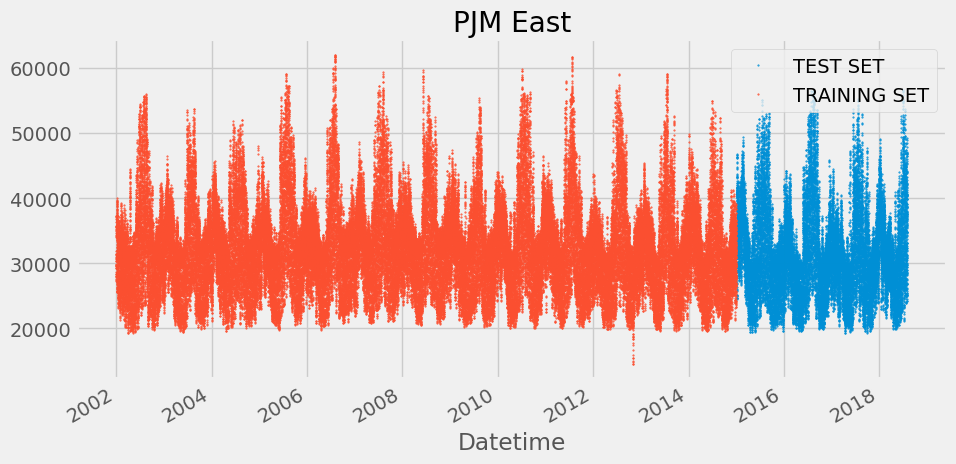

In [14]:
split_date = '1-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='PJM East', style='.', ms=1)
plt.show()

# Simple Prophet Model
Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.
Datetime column named: ds
target : y

In [15]:
pjme_train_prophet = pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

In [17]:
%%time
model = Prophet()
model.fit(pjme_train_prophet)

20:56:10 - cmdstanpy - INFO - Chain [1] start processing
20:57:11 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 8.55 s, sys: 509 ms, total: 9.06 s
Wall time: 1min 9s


In [18]:
pjme_test_prophet = pjme_test.reset_index().rename(columns={'Datetime':'ds','PJME_MW':'y'})

In [20]:
pjme_test_fcst = model.predict(pjme_test_prophet)

In [21]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31212.426583,23721.282590,32980.451657,31212.426583,31212.426583,-2860.285168,-2860.285168,-2860.285168,-4430.338451,...,1281.386862,1281.386862,1281.386862,288.666421,288.666421,288.666421,0.0,0.0,0.0,28352.141415
1,2015-01-01 02:00:00,31212.389624,22009.175910,31260.424987,31212.389624,31212.389624,-4364.670071,-4364.670071,-4364.670071,-5927.268583,...,1272.634801,1272.634801,1272.634801,289.963711,289.963711,289.963711,0.0,0.0,0.0,26847.719553
2,2015-01-01 03:00:00,31212.352665,21627.540923,30514.308420,31212.352665,31212.352665,-5236.379840,-5236.379840,-5236.379840,-6790.359208,...,1262.676841,1262.676841,1262.676841,291.302527,291.302527,291.302527,0.0,0.0,0.0,25975.972825
3,2015-01-01 04:00:00,31212.315706,21388.646732,30395.698741,31212.315706,31212.315706,-5377.931384,-5377.931384,-5377.931384,-6922.250813,...,1251.636535,1251.636535,1251.636535,292.682894,292.682894,292.682894,0.0,0.0,0.0,25834.384322
4,2015-01-01 05:00:00,31212.278747,21824.962125,30956.442754,31212.278747,31212.278747,-4703.576009,-4703.576009,-4703.576009,-6237.330492,...,1239.649646,1239.649646,1239.649646,294.104837,294.104837,294.104837,0.0,0.0,0.0,26508.702738


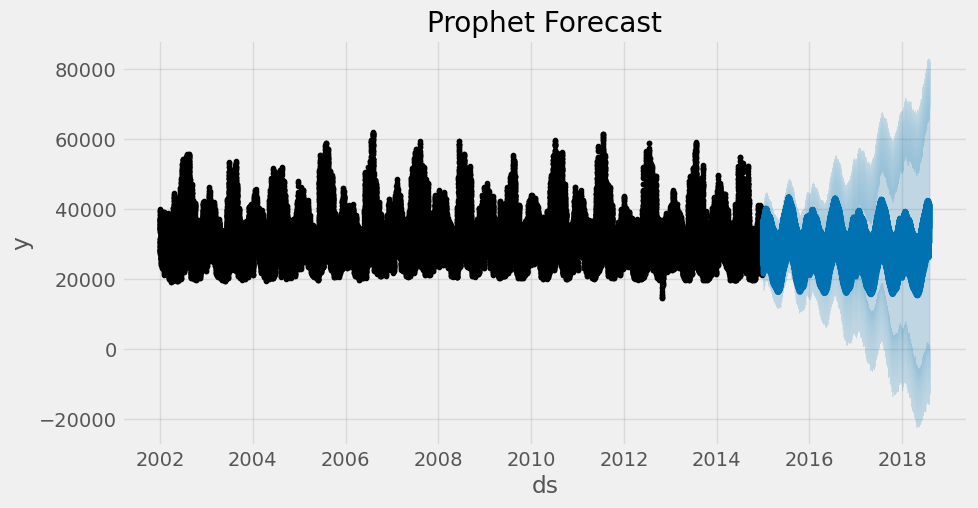

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

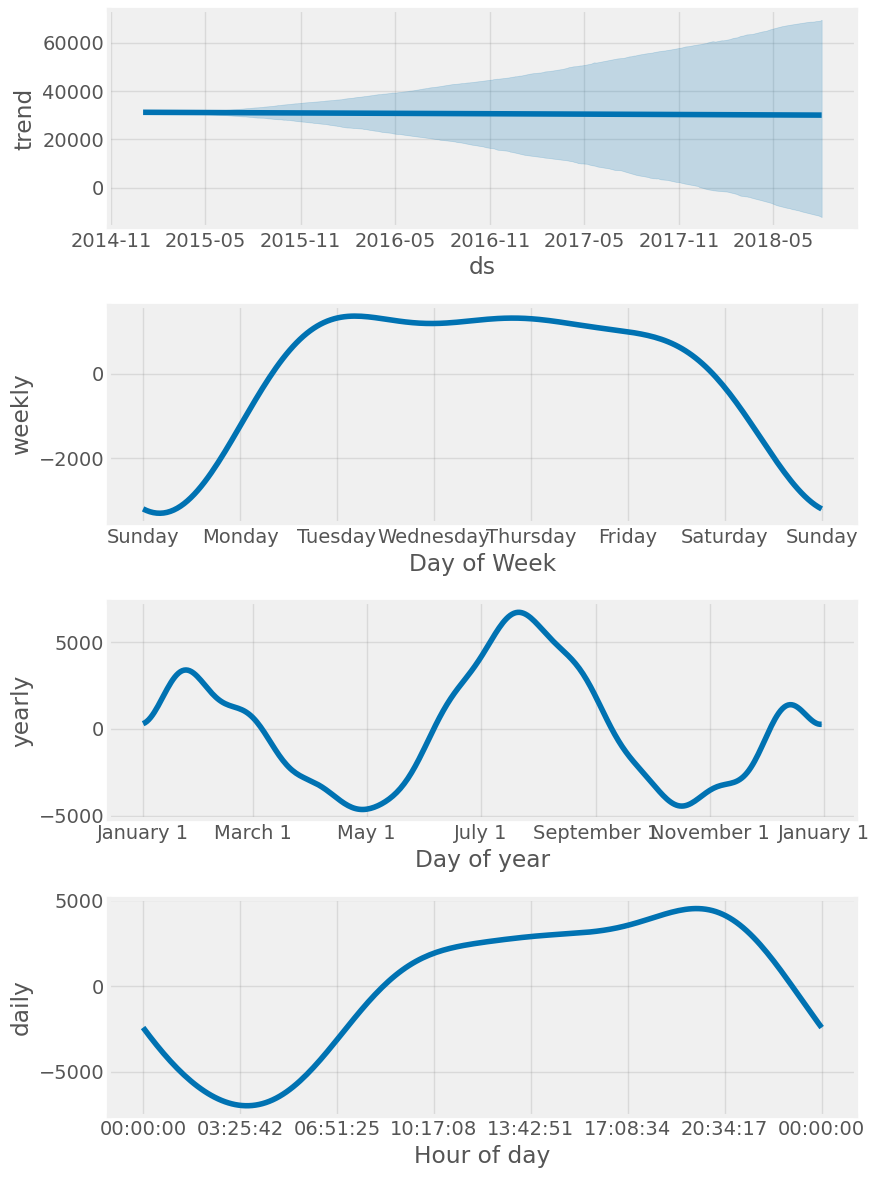

In [23]:
fig = model.plot_components(pjme_test_fcst)
plt.show()

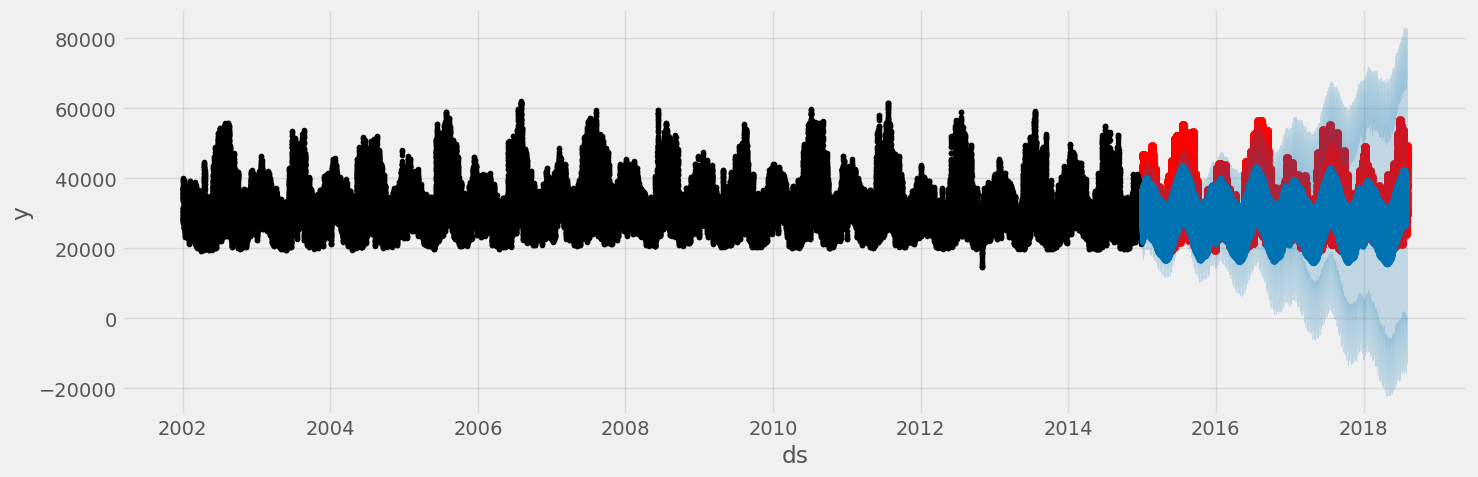

In [24]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

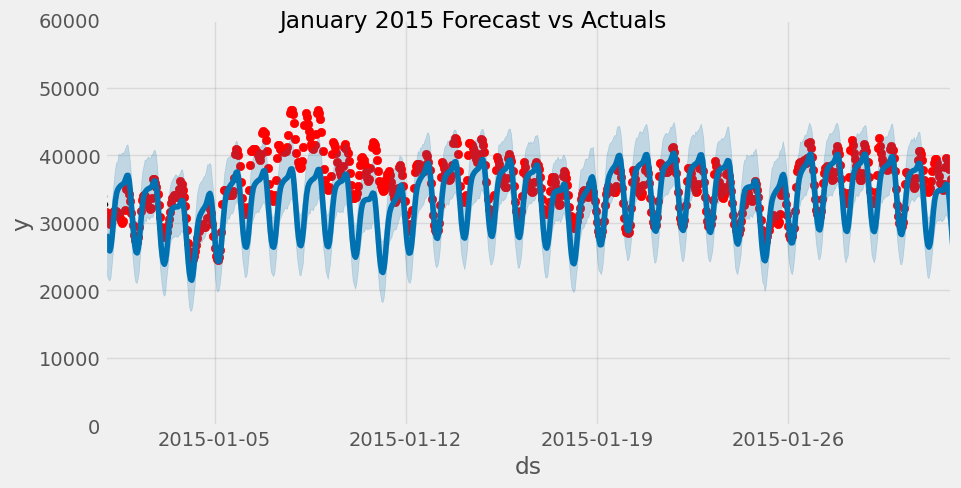

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2015',
              upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

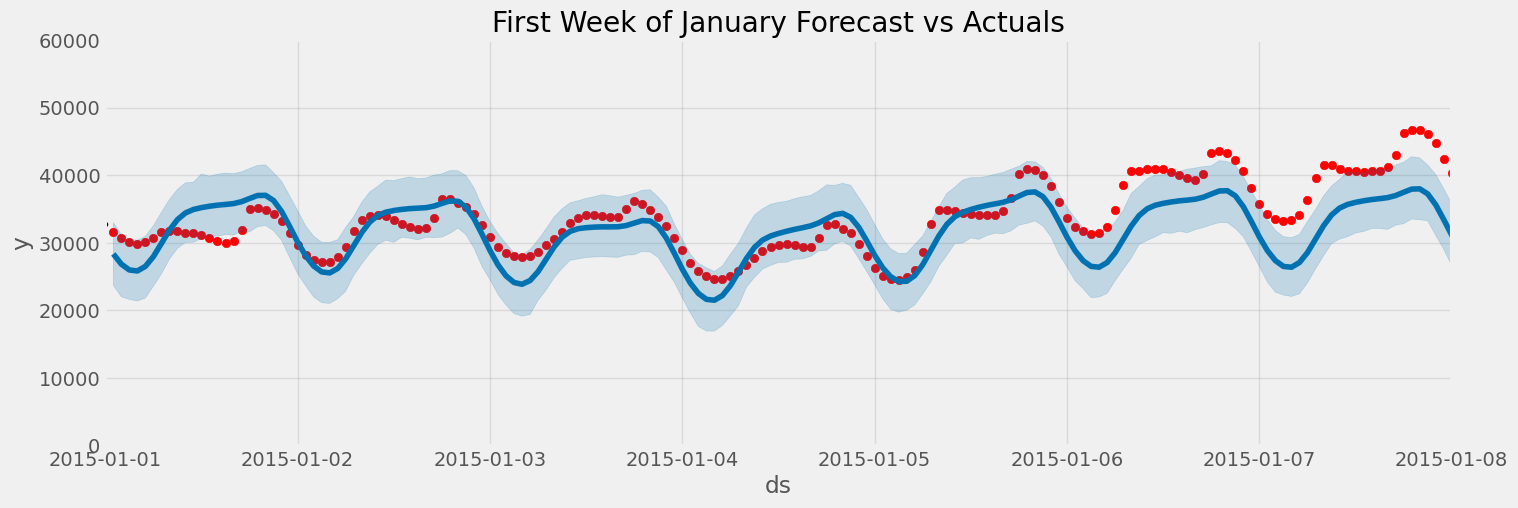

In [26]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
ax.set_title('First Week of January Forecast vs Actuals')
plt.show()

# Evaluate the model with Error Metrics

In [27]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat']))

6616.584175981253

In [28]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

5182.352421147546

In [29]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

16.512679848249924

In [30]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()


holidays = cal.holidays(start=pjme.index.min(),
                        end=pjme.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [31]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train_prophet)

21:04:14 - cmdstanpy - INFO - Chain [1] start processing
21:05:26 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 9.56 s, sys: 409 ms, total: 9.97 s
Wall time: 1min 21s


In [32]:
# Predict on training set with model
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test_prophet)

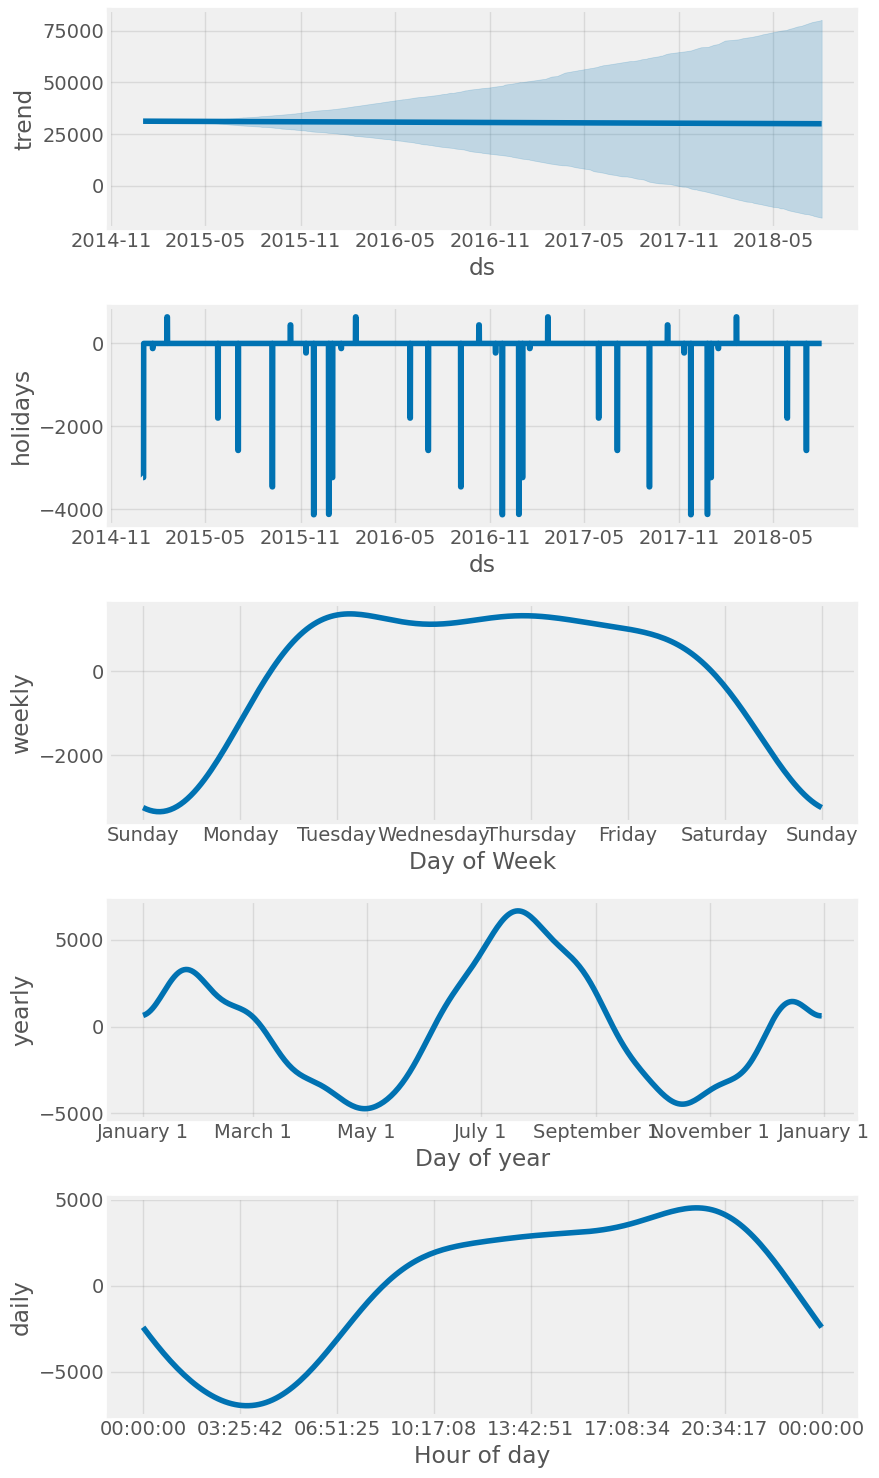

In [33]:
fig = model_with_holidays.plot_components(
    pjme_test_fcst_with_hols)
plt.show()

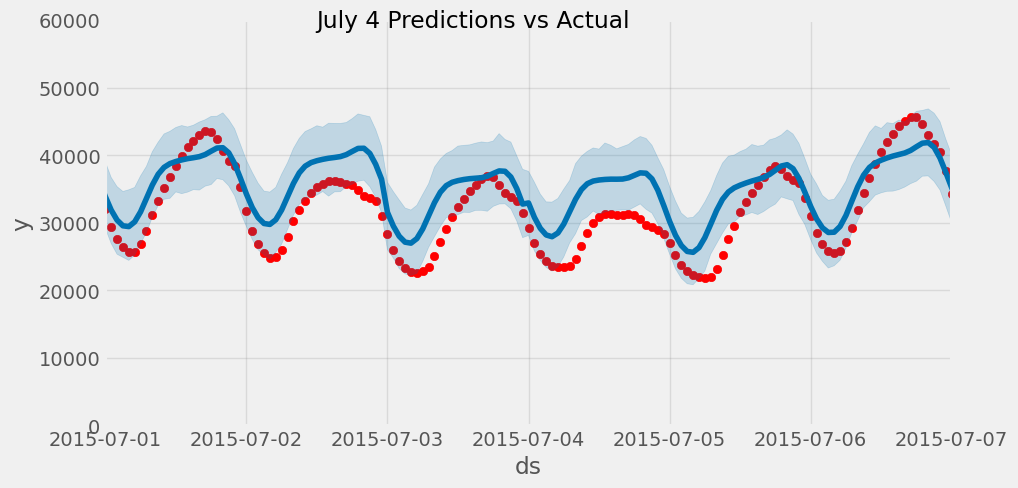

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst_with_hols, ax=ax)
ax.set_xbound(lower='07-01-2015',
              upper='07-07-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('July 4 Predictions vs Actual')

In [35]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat']))

6642.027152686474

In [36]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

5201.77663322832

In [37]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

16.559913124836058

In [39]:
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)
forecast = model_with_holidays.predict(future)

In [40]:
forecast[['ds','yhat']].head()

,ds,yhat
0,2015-01-01 01:00:00,25535.217948
1,2015-01-01 02:00:00,24033.296071
2,2015-01-01 03:00:00,23163.713911
3,2015-01-01 04:00:00,23023.976325
4,2015-01-01 05:00:00,23699.825556
